In [2]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD,SlopeOne, NMF, SVDpp, KNNBaseline, CoClustering, accuracy
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
#import implicit
#import tensorrec
%matplotlib inline

In [3]:
r=pd.read_csv('rating.csv')
r.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
movies=pd.read_csv('movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [6]:
movies['genres'] = movies['genres'].str.split('|')
movies['year']=movies['title'].str[-5:-1]
movies=movies[(movies['title'].str[-1]==')')&(movies['title'].str[-6]=='(')] #drop the movies without year in title
movies.year=pd.to_numeric(movies.year)
movies['Decade']=movies['year']//10 *10
movies=movies.set_index('movieId')
movies.sort_values('year').head()

,title,genres,year,Decade
movieId,,,,
129851,Dickson Greeting (1891),[(no genres listed)],1891,1890
95541,Blacksmith Scene (1893),[(no genres listed)],1893,1890
88674,Edison Kinetoscopic Record of a Sneeze (1894),[Documentary],1894,1890
94951,Dickson Experimental Sound Film (1894),[Musical],1894,1890
120869,Employees Leaving the Lumière Factory (1895),[Documentary],1895,1890


In [7]:
sep = movies.reset_index().set_index(['movieId','title','year'])['genres'].apply(pd.Series).stack()
sep = sep.reset_index()
sep.columns=['movieId','title','year','level','genres']
sep.to_csv('sep.csv')
print('Available Genres: ',sep.genres.unique())
sep.head()

Available Genres:  ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


,movieId,title,year,level,genres
0,1,Toy Story (1995),1995,0,Adventure
1,1,Toy Story (1995),1995,1,Animation
2,1,Toy Story (1995),1995,2,Children
3,1,Toy Story (1995),1995,3,Comedy
4,1,Toy Story (1995),1995,4,Fantasy


In [8]:
df = pd.merge(r,movies,on='movieId')
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
#chicagoGirl: The Social Network Takes on a Dictator (2013),3.666667,3
$ (Dollars) (1971),2.833333,24
$5 a Day (2008),2.871795,39
$9.99 (2008),3.009091,55
$ellebrity (Sellebrity) (2012),2.000000,2


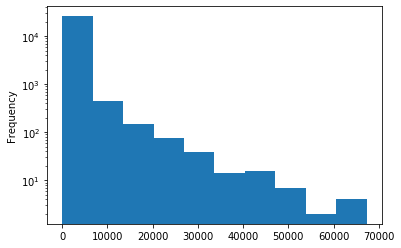

In [9]:
ratings['num of ratings'].plot(logy=True, kind='hist')
plt.show()

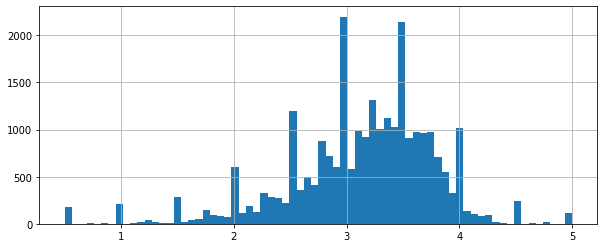

In [10]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.show()

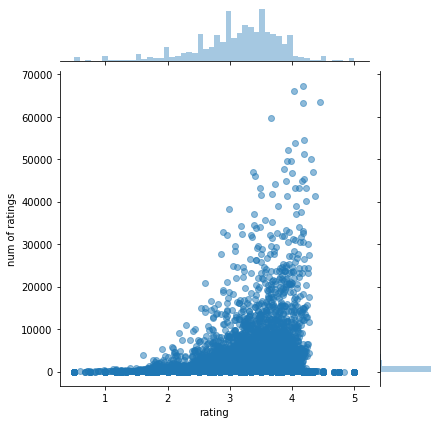

In [11]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.show()

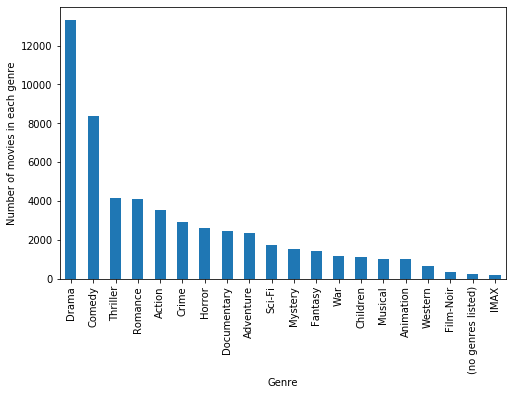

In [12]:
plt.figure(figsize=(8,5))
sep['genres'].value_counts().plot(kind='bar')
plt.ylabel('Number of movies in each genre')
plt.xlabel('Genre')
#plt.savefig('foo.png',dpi=300,bbox_inches='tight')
plt.show()

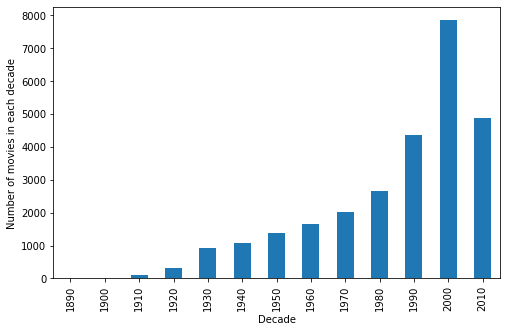

In [13]:
plt.figure(figsize=(8,5))
movies['Decade'].value_counts().sort_index().plot(kind='bar') 
plt.xlabel('Decade')
plt.ylabel('Number of movies in each decade')
#plt.savefig('foo1.png',dpi=300,bbox_inches='tight')
plt.show()

In [14]:
sep[sep['genres']=='Drama']['year'].value_counts().head(3)

2009    508
2007    474
2011    469
Name: year, dtype: int64

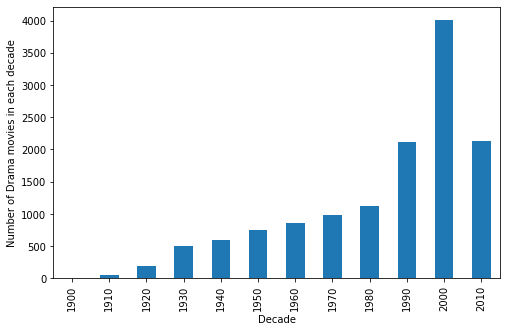

In [15]:
plt.figure(figsize=(8,5))
sep['Decade']=sep['year']//10 *10
sep[sep['genres']=='Drama']['Decade'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Decade')
plt.ylabel('Number of Drama movies in each decade')
#plt.savefig('foo2.png',dpi=300,bbox_inches='tight')
plt.show()

In [16]:
sum(movies['title'].value_counts()>1)

16

In [17]:
movies['title'].value_counts().head(16)

Girl, The (2012)                       2
Offside (2006)                         2
Blackout (2007)                        2
Aladdin (1992)                         2
Paradise (2013)                        2
Chaos (2005)                           2
Darling (2007)                         2
20,000 Leagues Under the Sea (1997)    2
War of the Worlds (2005)               2
Hamlet (2000)                          2
Clear History (2013)                   2
Emma (1996)                            2
Men with Guns (1997)                   2
Beneath (2013)                         2
Casanova (2005)                        2
Johnny Express (2014)                  2
Name: title, dtype: int64

In [18]:
movies['Name']=movies['title'].str[:-7] #removing the year from title
movies['Name'].value_counts().head(20)

Misérables, Les                 9
Hamlet                          8
Three Musketeers, The           7
Wuthering Heights               6
Alice in Wonderland             6
Christmas Carol, A              6
Jane Eyre                       5
Cinderella                      5
King Solomon's Mines            4
Eden                            4
Blackout                        4
Raven, The                      4
Cargo                           4
Carrie                          4
The Count of Monte Cristo       4
Maniac                          4
Emma                            4
20,000 Leagues Under the Sea    4
Dr. Jekyll and Mr. Hyde         4
Paradise                        4
Name: Name, dtype: int64

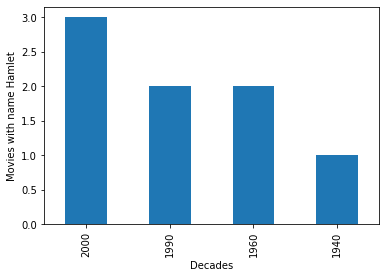

In [19]:
movies[movies.Name=='Hamlet'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Hamlet')
#plt.savefig('foo2.png',dpi=300,bbox_inches='tight')
plt.show()

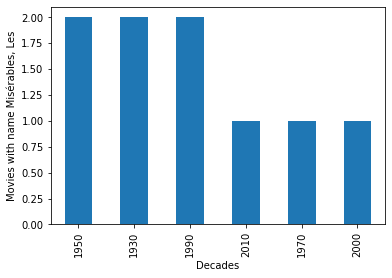

In [20]:
movies[movies.Name=='Misérables, Les'].sort_values(by='Decade').Decade.value_counts().plot(kind='bar')
plt.xlabel('Decades')
plt.ylabel('Movies with name Misérables, Les')
#plt.savefig('foo3.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
r.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

In [22]:
List=[]
for i in np.arange(4,5.5, 0.5):
    M=movies.loc[r[r.rating==i].movieId.value_counts().head(10).index,'title']
    print('Rate: %f' %i)
    print(M)
    print(' ')

Rate: 4.000000
593             Silence of the Lambs, The (1991)
457                         Fugitive, The (1993)
356                          Forrest Gump (1994)
480                         Jurassic Park (1993)
589            Terminator 2: Judgment Day (1991)
150                             Apollo 13 (1995)
1                               Toy Story (1995)
296                          Pulp Fiction (1994)
32     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
110                            Braveheart (1995)
Name: title, dtype: object
 
Rate: 4.500000
318                      Shawshank Redemption, The (1994)
2571                                   Matrix, The (1999)
296                                   Pulp Fiction (1994)
2959                                    Fight Club (1999)
4993    Lord of the Rings: The Fellowship of the Ring,...
5952        Lord of the Rings: The Two Towers, The (2002)
7153    Lord of the Rings: The Return of the King, The...
50                             Usual Suspects

In [23]:
r[r.movieId==318].rating.mean()

4.446990499637029

In [24]:
r[r.movieId==296].rating.mean() #Average rating for 'Pulp Fiction'

4.174231169217055

In [25]:
MaxRating=r['movieId'].value_counts().head(10)

In [26]:
movies.loc[MaxRating.index,'title']

296                           Pulp Fiction (1994)
356                           Forrest Gump (1994)
318              Shawshank Redemption, The (1994)
593              Silence of the Lambs, The (1991)
480                          Jurassic Park (1993)
260     Star Wars: Episode IV - A New Hope (1977)
110                             Braveheart (1995)
589             Terminator 2: Judgment Day (1991)
2571                           Matrix, The (1999)
527                       Schindler's List (1993)
Name: title, dtype: object

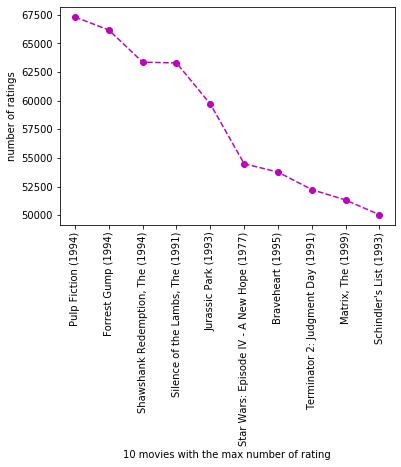

In [27]:
plt.plot(range(len(MaxRating)), MaxRating,'mo--')
plt.xticks(range(len(MaxRating)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('10 movies with the max number of rating')
plt.ylabel('number of ratings')
#plt.savefig('foo4.png',dpi=300,bbox_inches='tight')
plt.show()

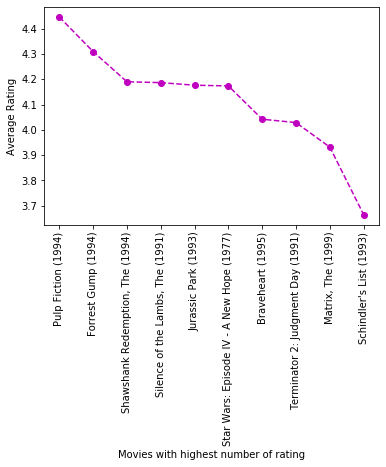

In [28]:
List5=[]
for i in MaxRating.index:
    List5.append(r[r.movieId==i].rating.mean())
plt.plot(range(len(List5)), sorted(List5,reverse=True),'mo--')
plt.xticks(range(len(List5)), movies.loc[MaxRating.index,'title'],rotation=90)
plt.xlabel('Movies with highest number of rating')
plt.ylabel('Average Rating')
#plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

In [29]:
MinRating=r['movieId'].value_counts()
MinRating=MinRating[MinRating==1]
print('Number of movies which are rated once:',movies.loc[MinRating.index,'title'].shape)

Number of movies which are rated once: (3972,)


C:\Users\arnab saha\Anaconda3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [30]:
r1= r.merge(sep.reset_index(), left_on='movieId', right_on='movieId', how='inner')
del r1['timestamp']
r1.head()

,userId,movieId,rating,index,title,year,level,genres,Decade
0,1,2,3.5,5,Jumanji (1995),1995,0,Adventure,1990
1,1,2,3.5,6,Jumanji (1995),1995,1,Children,1990
2,1,2,3.5,7,Jumanji (1995),1995,2,Fantasy,1990
3,5,2,3.0,5,Jumanji (1995),1995,0,Adventure,1990
4,5,2,3.0,6,Jumanji (1995),1995,1,Children,1990


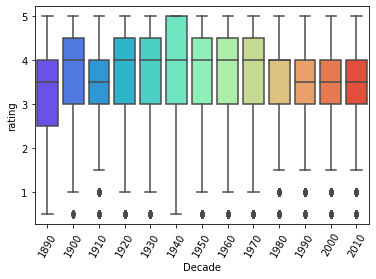

In [31]:
sns.boxplot(x='Decade', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=60)
#plt.savefig('foo5.png',dpi=300,bbox_inches='tight')
plt.show()

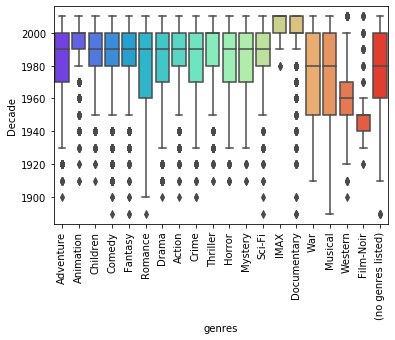

In [32]:
sns.boxplot(x='genres', y='Decade', data=sep,palette='rainbow')
plt.xticks(rotation=90)
#plt.savefig('foo6.png',dpi=300,bbox_inches='tight')
plt.show()

In [33]:
ID=r1.userId.value_counts().head(10) #UserID wih highest number of rating
List5=[]
for i in ID.index:
    List5.append(r1[r1.userId==i]['rating'].mean())

List5

[3.2907795987134323,
 3.2125222624823437,
 1.6553183229813664,
 3.0261211460604174,
 2.7801474047357693,
 3.764897466827503,
 3.4983650780675224,
 3.225354490209318,
 2.498365450791466,
 3.3196820944366525]

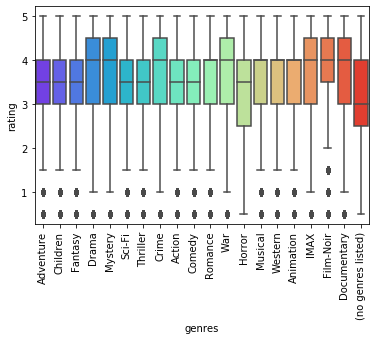

In [34]:
sns.boxplot(x='genres', y='rating', data=r1,palette='rainbow')
plt.xticks(rotation=90)
#plt.savefig('foo7.png',dpi=300,bbox_inches='tight')
plt.show()

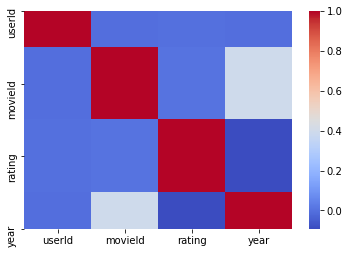

In [35]:
sns.heatmap(r1[['userId','movieId','rating','year']].corr(),cmap='coolwarm')
plt.show()

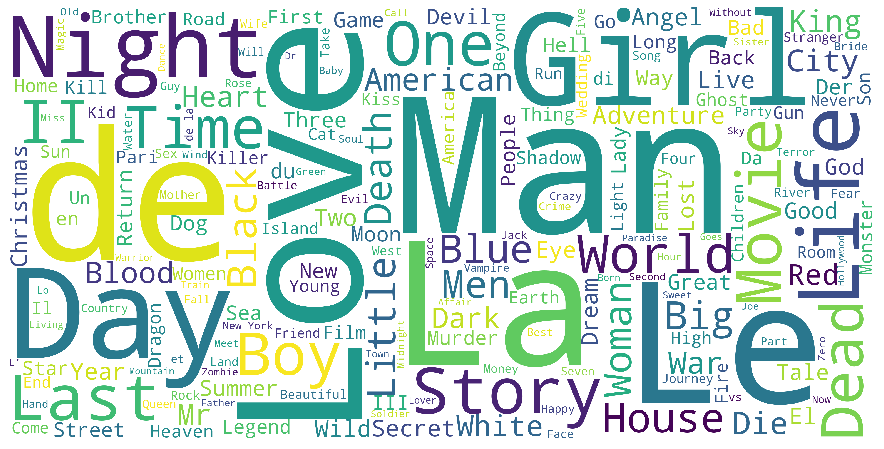

In [35]:
movies['title'] = movies['title'].astype('str')

title_corpus = ' '.join(movies['title'])

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.savefig('world1.png',dpi=300,bbox_inches='tight')
plt.show()

# Recomender System

Preparing the data

In [36]:
movielens=r.drop(['timestamp'],axis=1)
movielens=movielens.iloc[(r.userId.value_counts()>100).index,:]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(movielens[['userId','movieId']],movielens['rating'],test_size=0.25, 
                                                  random_state=55)

y_train=pd.DataFrame(y_train)
train=X_train.join(y_train)

y_test=pd.DataFrame(y_test)
test=X_test.join(y_test)

In [38]:
r1=r1[['userId','movieId','rating','title','genres']]
r1.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure
1,1,2,3.5,Jumanji (1995),Children
2,1,2,3.5,Jumanji (1995),Fantasy
3,5,2,3.0,Jumanji (1995),Adventure
4,5,2,3.0,Jumanji (1995),Children


In [39]:
a=r1[r1.genres=='Drama'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>4.1)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Drama')&(r1.movieId==i)].title.iloc[0])

1 : Pulp Fiction (1994)
2 : Shawshank Redemption, The (1994)
3 : Schindler's List (1993)
4 : American Beauty (1999)
5 : Fargo (1996)
6 : Godfather, The (1972)
7 : Fight Club (1999)
8 : Lord of the Rings: The Return of the King, The (2003)
9 : One Flew Over the Cuckoo's Nest (1975)
10 : Godfather: Part II, The (1974)


In [40]:
a=r1[r1.genres=='Romance'].movieId.value_counts().head(30).index
count=0
for i in a:
    if (r1[(r1.movieId==i)].rating.mean()>3.5)&(count<10):
        count+=1
        print(count,':',r1[(r1.genres=='Romance')&(r1.movieId==i)].title.iloc[0])

1 : Forrest Gump (1994)
2 : Beauty and the Beast (1991)
3 : Princess Bride, The (1987)
4 : Groundhog Day (1993)
5 : Shrek (2001)
6 : Sleepless in Seattle (1993)
7 : Good Will Hunting (1997)
8 : Four Weddings and a Funeral (1994)
9 : Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
10 : There's Something About Mary (1998)


# 2- IMDB Weighted Rating Formula

Another technique could be IMDB's weighted rating formula which is mathematically represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,

v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [39]:
C=r1.groupby('movieId').rating.mean().mean()
m=r1.movieId.value_counts().quantile(0.95)
print(' mean vote across the whole report (C):',C)
print('minimum votes required to be listed in the chart (m):',m)

 mean vote across the whole report (C): 3.133021933434738
minimum votes required to be listed in the chart (m): 8382.399999999907


In [40]:
a=r1.movieId.value_counts().sort_index()
b=r1.groupby('movieId').rating.mean()
print('Number of Movies which are qualified:',sum((a>m)&(b>C)))

Number of Movies which are qualified: 1068


In [41]:
a=pd.DataFrame(a.values,columns=['counts'],index=a.index)
b=pd.DataFrame(b.values,columns=['mean'],index=b.index)
df=pd.concat([a,b], axis=1, sort=False)
qualified = df[(df['counts'] >= m)  & (df['mean']>=C)]
print(qualified.shape[0],' movies are qualified')

1068  movies are qualified


In [42]:
def weighted_rating(x):
    v = x['counts']
    R = x['mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False)

List1=[]
for i in qualified.head(30).index:
    List1.append(movies[movies.index==i]['title'].values)
IMDBBest=pd.DataFrame(List1,columns=['Best to Recommend'])
IMDBBest

C:\Users\arnab saha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Best to Recommend
0,"Shawshank Redemption, The (1994)"
1,"Usual Suspects, The (1995)"
2,"Godfather, The (1972)"
3,Schindler's List (1993)
4,Fight Club (1999)
5,Pulp Fiction (1994)
6,Star Wars: Episode IV - A New Hope (1977)
7,"Silence of the Lambs, The (1991)"
8,"Matrix, The (1999)"
9,Star Wars: Episode V - The Empire Strikes Back...


# Collaborative Filtering Algortihm

Learnt this algorithm from Kaggle

In [3]:
movies=pd.read_csv('movie.csv')
r=pd.read_csv('rating.csv')

In [4]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
r.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
print("Total number of movies =", movies.shape[0])
print("Total number of unique movies =", len(movies.movieId.unique()))
print("")
print("Total number of user ratings =", r.shape[0])
print("Total number of unique users =", len(r.userId.unique()))

Total number of movies = 27278
Total number of unique movies = 27278

Total number of user ratings = 20000263
Total number of unique users = 138493


In [7]:
movie_data_all = movies.drop(['genres'], axis=1)
rating_data_all = r.drop(['timestamp'], axis=1)

Select few most popular movies, from two distinct genres. In this particular example, we considered movies of genres "Action" and "Romance".
The objective is to find if collborative filtering algorithm can successfully learn the features of these movies based on user ratings, such that we can clearly distinguish their genres and recommend accordingly.

In [8]:
top_action_movies = ['Dark Knight, The', 'Lord of the Rings: The Return of the King', 
                     'Inception', 'Star Wars: Episode V - The Empire Strikes Back',
                     'Matrix, The']
top_romantic_movies = ['Notting Hill', 'Love Story \(1970\)', 'When Harry Met Sally',
                       'Titanic \(1997\)', 'Pretty Woman']
top_movies = top_action_movies + top_romantic_movies

movie_data = movie_data_all[movie_data_all.title.str.contains('|'.join(top_movies))]
movie_data

,movieId,title
591,597,Pretty Woman (1990)
1171,1196,Star Wars: Episode V - The Empire Strikes Back...
1278,1307,When Harry Met Sally... (1989)
1661,1721,Titanic (1997)
2486,2571,"Matrix, The (1999)"
2585,2671,Notting Hill (1999)
4201,4296,Love Story (1970)
7041,7153,"Lord of the Rings: The Return of the King, The..."
12525,58559,"Dark Knight, The (2008)"
15534,79132,Inception (2010)


In [9]:
rating_data = rating_data_all.iloc[:, :]

##### Merge movie and rating dataset based on movieId column

In [10]:
movie_rating_merged_data = movie_data.merge(rating_data, on='movieId', how='inner')
movie_rating_merged_data.head()

,movieId,title,userId,rating
0,597,Pretty Woman (1990),7,4.0
1,597,Pretty Woman (1990),8,5.0
2,597,Pretty Woman (1990),11,4.5
3,597,Pretty Woman (1990),13,5.0
4,597,Pretty Woman (1990),24,3.0


In [11]:
movie_rating_merged_data[movie_rating_merged_data.title == 'Pretty Woman (1990)']['rating'].mean()

3.420427728613569

In [12]:
movie_rating_merged_data.groupby(['title'], sort=False)['rating'].mean().sort_values(ascending=False).head(10)

title
Dark Knight, The (2008)                                  4.220129
Star Wars: Episode V - The Empire Strikes Back (1980)    4.188202
Matrix, The (1999)                                       4.187186
Inception (2010)                                         4.156172
Lord of the Rings: The Return of the King, The (2003)    4.142382
When Harry Met Sally... (1989)                           3.842996
Notting Hill (1999)                                      3.453924
Pretty Woman (1990)                                      3.420428
Titanic (1997)                                           3.338188
Love Story (1970)                                        3.173618
Name: rating, dtype: float64

### Build Collaborative Filtering Model

Create a pivot table of movies (on rows) and corresponsing user ratings (on columns). The pivot table will contain the ratings of only selected movies.

Thus, rows = movies and columns = users

In [13]:
movie_rating_merged_pivot = pd.pivot_table(movie_rating_merged_data,
                                           index=['title'],
                                           columns=['userId'],
                                           values=['rating'],
                                           dropna=False,
                                           fill_value=0
                                          )
movie_rating_merged_pivot.shape

(10, 94160)

In [14]:
Y = movie_rating_merged_pivot

#### Create a matrix R, such that, R(i,j) = 1 iff User j has selected a rating for Movie i. R(i,j) = 0 otherwise.

In [15]:
R = np.ones(Y.shape)
no_rating_idx = np.where(Y == 0.0)
R[no_rating_idx] = 0
R

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

Assign n_m (number of movies), n_u (number of users) and n_f (number of features)

In [16]:
n_u = Y.shape[1]
n_m = Y.shape[0]
n_f = 2

Assign random initial values to movie and user parameters.

X = parameters of movies (each row represent a movie)

Theta = parameters of users (each row represent a user)

In [17]:
np.random.seed(7)
Initial_X = np.random.rand(n_m, n_f)
Initial_Theta = np.random.rand(n_u, n_f)

Cost function or Objective function of collborative filtering algorithm


In [18]:
def collabFilterCostFunction(X, Theta, Y, R, reg_lambda):
    cost = 0
    error = (np.dot(X, Theta.T) - Y) * R
    error_sq = np.power(error, 2)
    cost = np.sum(np.sum(error_sq)) / 2
    cost = cost + ((reg_lambda/2) * ( np.sum(np.sum((np.power(X, 2)))) + np.sum(np.sum((np.power(Theta, 2))))))
    return cost

Computation of Gradient Descent of collaborative filtering algorithm

In [19]:
# Gradient Descent
def collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters):
    cost_history = np.zeros([num_iters, 1])
    
    for i in range(num_iters):
        error = (np.dot(X, Theta.T) - Y) * R
        X_grad = np.dot(error, Theta) + reg_lambda * X
        Theta_grad = np.dot(error.T, X) + reg_lambda * Theta
        
        X = X - alpha * X_grad 
        Theta = Theta - alpha * Theta_grad
        
        cost_history[i] = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
        
    return X, Theta, cost_history

Train the collborative filtering model

In [20]:
# Tune hyperparameters
alpha = 0.0001
num_iters = 100
reg_lambda = 1

# Perform gradient descent to find optimal parameters
X, Theta = Initial_X, Initial_Theta
X, Theta, cost_history = collabFilterGradientDescent(X, Theta, Y, R, alpha, reg_lambda, num_iters)
cost = collabFilterCostFunction(X, Theta, Y, R, reg_lambda)
print("Final cost =", cost)

Final cost = 129765.32800120284


Plot cost vs number of iterations

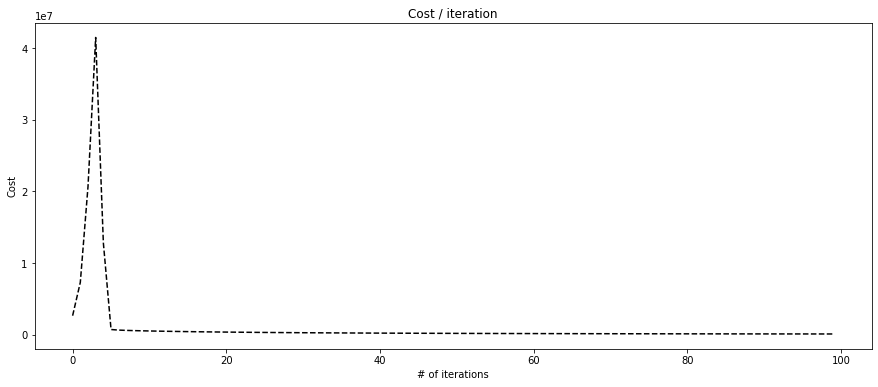

In [21]:
fig, axes = plt.subplots(figsize=(15,6))
axes.plot(cost_history, 'k--')
axes.set_xlabel('# of iterations')
axes.set_ylabel('Cost')
axes.set_title('Cost / iteration')
plt.show()

Since we have considered only 2 genres (and hence 2 features), we plot the learned feature parameters of movies to visualize the pattern.

We find below that the algorithm has learnt the features pretty well and hence the movies of same genre and clustered together.

In this particular example, we considered movies of genres "Action" and "Romance". From the visualization, it can be concluded that one axis represents "Degree of Action" and another axis represents "Degree of Romance".

As a next step, we can run K-Means clustering to further verify our understanding.

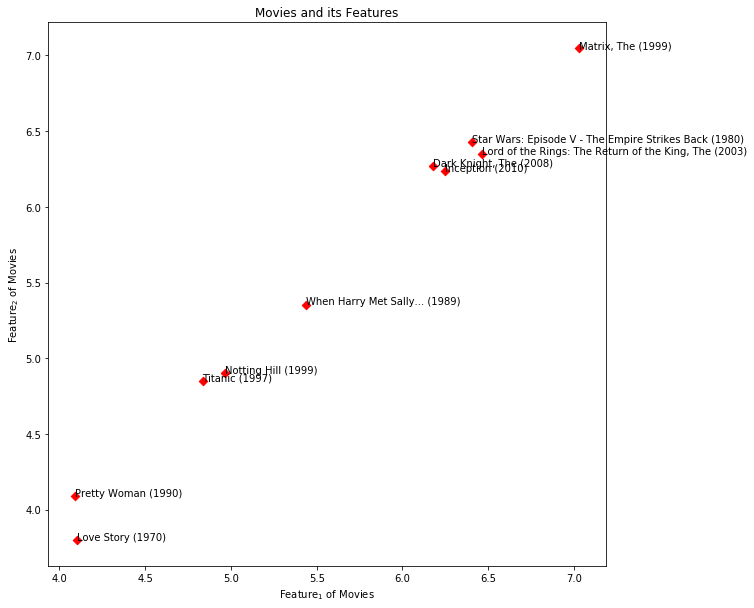

In [22]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(X[:,0], X[:,1], color='red', marker='D')

for val, movie in zip(X, Y.index):
    axes.text(val[0], val[1], movie)

axes.set_xlabel('Feature$_1$ of Movies')
axes.set_ylabel('Feature$_2$ of Movies')
axes.set_title('Movies and its Features')
plt.show()

#### For a random user, what are her preferred movies, and what is our recommendation for her based on result of collaborative filtering algorithm?

In [23]:
user_idx = np.random.randint(n_u)
pred_rating = []
print("Original rating of an user:\n", Y.iloc[:,user_idx].sort_values(ascending=False))

predicted_ratings = np.dot(X, Theta.T)
predicted_ratings = sorted(zip(predicted_ratings[:,user_idx], Y.index), reverse=True)
print("\nPredicted rating of the same user:")
_ = [print(rating, movie) for rating, movie in predicted_ratings]

Original rating of an user:
 title
Inception (2010)                                         4.5
Dark Knight, The (2008)                                  4.0
When Harry Met Sally... (1989)                           3.5
Matrix, The (1999)                                       3.5
Lord of the Rings: The Return of the King, The (2003)    3.0
Titanic (1997)                                           0.0
Star Wars: Episode V - The Empire Strikes Back (1980)    0.0
Pretty Woman (1990)                                      0.0
Notting Hill (1999)                                      0.0
Love Story (1970)                                        0.0
Name: (rating, 40002), dtype: float64

Predicted rating of the same user:
4.014181744219707 Matrix, The (1999)
3.6607418454167227 Star Wars: Episode V - The Empire Strikes Back (1980)
3.613381131795258 Lord of the Rings: The Return of the King, The (2003)
3.573550901700217 Dark Knight, The (2008)
3.552357033671688 Inception (2010)
3.04800310884118 When 